# Predicting $t_{1/2}$ in TREBL-seq data using ADHunter vs. regressions

In [1]:
%load_ext autoreload
%autoreload 2 

%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

from sklearn import preprocessing
import pytorch_lightning as pl
from actpred.models import ActCNNSystem
from actpred.utils import get_threshold#, get_stratified_split

from scipy.stats import spearmanr, pearsonr
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import os
from Bio.Seq import Seq

from sklearn.metrics import r2_score
import re
from itertools import product
from sklearn.linear_model import LinearRegression
# pl.seed_everything(0)

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit

def get_stratified_split(X,
                         y_bin,
                         y_cont,
                         as_tensor=True,
                         return_onehot=False,
                         seed=0):

    splitter0 = StratifiedShuffleSplit(n_splits=1,
                                      train_size=0.8,
                                      random_state=seed)
    train_index, val_test_index = list(splitter0.split(X, y_bin))[0]

    X_train = X[train_index]
    y_bin_train = y_bin[train_index]
    y_cont_train = y_cont[train_index]

    X_val_test = X[val_test_index]
    y_bin_val_test = y_bin[val_test_index]
    y_cont_val_test = y_cont[val_test_index]

    splitter1 = StratifiedShuffleSplit(n_splits=1,
                                      train_size=0.5,
                                      random_state=seed)
    val_index, test_index = list(splitter1.split(X_val_test, y_bin_val_test))[0]
    X_val = X_val_test[val_index]
    y_bin_val = y_bin_val_test[val_index]
    y_cont_val = y_cont_val_test[val_index]

    X_test = X_val_test[test_index]
    y_bin_test = y_bin_val_test[test_index]
    y_cont_test = y_cont_val_test[test_index]

    if return_onehot:
        enc = preprocessing.OneHotEncoder()
        enc.fit(X)
        X_train_one_hot, X_val_one_hot, X_test_one_hot = map(
            enc.transform, (X_train, X_val, X_test))
        # Convert to dense arrays
        X_train_one_hot = X_train_one_hot.toarray().astype(np.float32)
        X_val_one_hot = X_val_one_hot.toarray().astype(np.float32)
        X_test_one_hot = X_test_one_hot.toarray().astype(np.float32)        

        if as_tensor:
            X_train = torch.tensor(X_train)
            X_train_one_hot = torch.tensor(X_train_one_hot)
            y_bin_train = torch.tensor(y_bin_train)
            y_cont_train = torch.tensor(y_cont_train)

            X_val = torch.tensor(X_val)
            X_val_one_hot = torch.tensor(X_val_one_hot)
            y_bin_val = torch.tensor(y_bin_val)
            y_cont_val = torch.tensor(y_cont_val)

            X_test = torch.tensor(X_test)
            X_test_one_hot = torch.tensor(X_test_one_hot)
            y_bin_test = torch.tensor(y_bin_test)
            y_cont_test = torch.tensor(y_cont_test)
        return (X_train, X_train_one_hot, y_bin_train, y_cont_train), \
            (X_val, X_val_one_hot, y_bin_val, y_cont_val), \
            (X_test, X_test_one_hot, y_bin_test, y_cont_test)
    else:
        if as_tensor:
            X_train = torch.tensor(X_train)
            y_bin_train = torch.tensor(y_bin_train)
            y_cont_train = torch.tensor(y_cont_train)

            X_val = torch.tensor(X_val)
            y_bin_val = torch.tensor(y_bin_val)
            y_cont_val = torch.tensor(y_cont_val)

            X_test = torch.tensor(X_test)
            y_bin_test = torch.tensor(y_bin_test)
            y_cont_test = torch.tensor(y_cont_test)
        return (X_train, y_bin_train, y_cont_train), \
            (X_val, y_bin_val, y_cont_val), \
            (X_test, y_bin_test, y_cont_test), \
            (train_index, val_index, test_index)


def train_adhunter(X_train, y_cont_train, X_val, y_cont_val, X_test, y_cont_test):
    # Create Training and Validation Datasets
    bs = 128
    train_ds = TensorDataset(X_train, y_cont_train.to(torch.float))
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

    val_ds = TensorDataset(X_val, y_cont_val.to(torch.float))
    val_dl = DataLoader(val_ds, batch_size=bs)
    # Load pretrained model
    kernel_size = 5
    dilation = 3 
    hidden = 64

    model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3)
    model.load_state_dict(torch.load("../adhunter/adhunter_1he.pt"))
    # Train ADHunter
    dirpath="../misc/models"
    csv_logger = CSVLogger('../misc/logs')
    checkpoint_callback = ModelCheckpoint(dirpath=dirpath, monitor="val_loss", filename="min_val_loss", save_last=True)
    patience=10
    early_stopping = EarlyStopping('val_loss', patience=patience)

    trainer = pl.Trainer(accelerator="gpu", devices=1, callbacks=[checkpoint_callback, early_stopping], logger=[csv_logger], max_epochs=100)
    trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)
    # Load the best model
    ckpt_dict = torch.load(checkpoint_callback.best_model_path)
    model.load_state_dict(ckpt_dict["state_dict"])
    # Get correlations
    y_pred = model(X_test).detach().numpy().flatten()
    y_te = y_cont_test.detach().numpy().flatten()
    spearman_r = spearmanr(y_te, y_pred).statistic
    pearson_r = pearsonr(y_te, y_pred).statistic
    r2 = r2_score(y_te, y_pred)
    return spearman_r, pearson_r, r2

def train_test_split_copy(X, y, train_indices, test_indices):
    # Use predetermined train test indices to split data
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

## Single run

Load in the data and generate train-test split, stratifying on $t_{1/2}$

In [17]:
df = pd.read_csv("../data/EC_TREBLactivities_20250321_v2.csv")
df["AAseq"] = df["Tile"].apply(lambda seq: "".join(Seq(seq).translate()))
# print(sum(df[df["AAseq"].str.len() == 40]) / len(df))
df = df[df["AAseq"].str.len() == 40]
df = df.loc[df.loc[:, ['AAseq', 'Vmax']].drop_duplicates().index]
df_ad = df[df["Activity"]=="active"].copy()

seqs = df_ad["AAseq"].to_numpy()
# activity = df["Vmax"].to_numpy()
# y_bin = (df_ad["Activity"] == "active").values


t_half = df_ad["T1/2"].to_numpy().reshape(-1, 1)
t_scaler = preprocessing.StandardScaler().fit(t_half)
t_half_scaled = t_scaler.transform(t_half)
y_cont = t_half_scaled
# Split t1/2 into above/below median
t_half_median = np.median(t_half)
y_bin = t_half > t_half_median
# Add speed annotations to df_ad
df_ad["speed"] = "fast"
df_ad.loc[y_bin.flatten(), "speed"] = "slow"


# convert seqs to integer valued vectors
alphabet="ACDEFGHIKLMNPQRSTVWY"
aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
i_to_aa = {i:aa for i, aa in enumerate(alphabet)}
X = np.asarray([[aa_to_i[aa] for aa in x] for x in seqs])
# Do train test split
train, val, test, indices = get_stratified_split(X, y_bin, y_cont, as_tensor=True)
(X_train, y_bin_train, y_cont_train) = train
(X_val, y_bin_val, y_cont_val) = val
(X_test, y_bin_test, y_cont_test) = test
test_idx, val_idx = indices

test_val_indices = np.concatenate(indices)
train_indices = np.array([i for i in np.arange(len(X)) if i not in test_val_indices])

### Train regressions

In [18]:

# np.char.count(seqs[0], "AA"), seqs[0]
count_kmers = lambda seq, pair: seq.count(pair)
dipeptides = ["".join(j) for j in [i for i in product(alphabet, repeat=2)]]
# dipeptides = ["".join(j) for j in [i for i in combinations(alphabet, 2)]]
get_input_2mers = lambda seq: np.array([count_kmers(seq, pair) for pair in dipeptides])
get_input_single = lambda seq: np.array([count_kmers(seq, aa) for aa in alphabet])
# Additional functions to double count where applicable: eg AAAA -> 4 AA instead of 2 AA
count_kmers_all = lambda seq, pair: len(re.findall(f'(?=({pair}))', seq))
get_input_2mers_all = lambda seq: np.array([count_kmers(seq, pair) for pair in dipeptides])

# X_2mers = np.vstack(df["AAseq"].apply(get_input_2mers).values)
X_2mers = np.vstack(df_ad["AAseq"].apply(get_input_2mers_all).values)
X_aa = np.vstack(df_ad["AAseq"].apply(get_input_single).values)
X_combined = np.hstack([X_2mers, X_aa])

In [19]:
# from sklearn.model_selection import train_test_split



X_2mer_train, X_2mer_test, y_2mer_train, y_2mer_test = train_test_split_copy(X_2mers, y_cont, train_indices, test_val_indices)
X_aa_train, X_aa_test, y_aa_train, y_aa_test = train_test_split_copy(X_aa, y_cont, train_indices, test_val_indices)
X_comb_train, X_comb_test, y_comb_train, y_comb_test = train_test_split_copy(X_combined, y_cont, train_indices, test_val_indices)


# X_2mer_train, X_2mer_test, y_2mer_train, y_2mer_test = train_test_split(X_2mers, y_cont, stratify=y_bin, train_size=.8)
# X_aa_train, X_aa_test, y_aa_train, y_aa_test = train_test_split(X_aa, y_cont, stratify=y_bin, train_size=.8)
# X_comb_train, X_comb_test, y_comb_train, y_comb_test = train_test_split(X_combined, y_cont, stratify=y_bin, train_size=.8)

In [20]:
regr = LinearRegression()
regr.fit(X_2mer_train, y_2mer_train)
r2_2mer = regr.score(X_2mer_test, y_2mer_test)
print(r2_2mer) 

regr_single = LinearRegression()
regr_single.fit(X_aa_train, y_aa_train)
r2_aa = regr_single.score(X_aa_test, y_aa_test)
print(r2_aa) 

regr_comb = LinearRegression()
regr_comb.fit(X_comb_train, y_comb_train)
r2_comb = regr_comb.score(X_comb_test, y_comb_test)
print(r2_comb) 

sp_r_2mer, _ = spearmanr(regr.predict(X_2mer_test), y_2mer_test)
sp_r_aa, _ = spearmanr(regr_single.predict(X_aa_test), y_aa_test)
sp_r_comb, _ = spearmanr(regr_comb.predict(X_comb_test), y_comb_test)

-0.34175646785195757
0.1781086468147688
-0.5109602712516716


### Train ADHunter

In [21]:
sp, pe, r2 = train_adhunter(X_train, y_cont_train, X_val, y_cont_val, X_test, y_cont_test)

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ActCNN           | 96.8 K
1 | loss_fn   | MSELoss          | 0     
2 | rmse      | MeanSquaredError | 0     
3 | pearsonr  | PearsonCorrCoef  | 0     
4 | spearmanr | SpearmanCorrCoef | 0     
-----------------------------------------------
96.8 K    Trainable params
0         Non-trainable params
96.8 K    Total params
0.387     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 82.17it/s] val_rmse 1.9252488613128662
val_pearsonr -0.1572374701499939
val_spearmanr -0.4634172320365906
                                                                           

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning

Epoch 0: 100%|██████████| 18/18 [00:00<00:00, 77.21it/s, loss=0.889, v_num=0]val_rmse 1.0917143821716309
val_pearsonr 0.15447400510311127
val_spearmanr 0.38585609197616577
Epoch 1: 100%|██████████| 18/18 [00:00<00:00, 91.95it/s, loss=0.807, v_num=0]val_rmse 1.052364706993103
val_pearsonr 0.193476602435112
val_spearmanr 0.4065026044845581
Epoch 2: 100%|██████████| 18/18 [00:00<00:00, 88.68it/s, loss=0.602, v_num=0]val_rmse 1.085295557975769
val_pearsonr 0.0882691890001297
val_spearmanr 0.08887292444705963
Epoch 3: 100%|██████████| 18/18 [00:00<00:00, 86.43it/s, loss=0.449, v_num=0]val_rmse 1.1503127813339233
val_pearsonr 0.026952818036079407
val_spearmanr 0.1802476942539215
Epoch 4: 100%|██████████| 18/18 [00:00<00:00, 92.57it/s, loss=0.364, v_num=0]val_rmse 1.18717360496521
val_pearsonr 0.10258927196264267
val_spearmanr 0.28204208612442017
Epoch 5: 100%|██████████| 18/18 [00:00<00:00, 85.48it/s, loss=0.464, v_num=0]val_rmse 1.2857849597930908
val_pearsonr 0.04378564655780792
val_spearm

/var/folders/1w/3zhjqj3d3ljgvrrqp77lpv6m0000gn/T/ipykernel_13738/1901032471.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot({


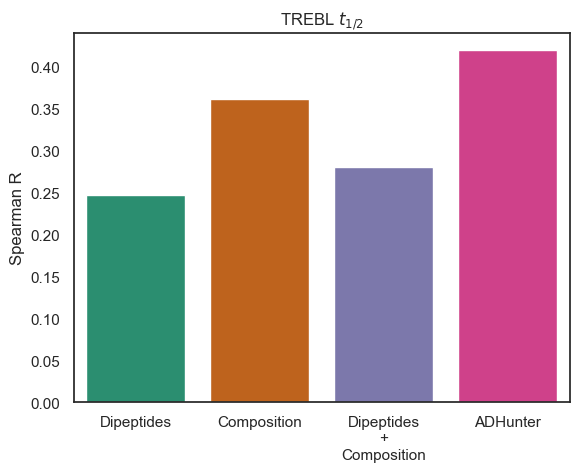

In [22]:
sns.barplot({
    "Dipeptides": sp_r_2mer, 
    "Composition": sp_r_aa, 
    "Dipeptides\n+\nComposition": sp_r_comb,
    "ADHunter": sp,
    }, errorbar=None, palette='Dark2')
plt.ylabel("Spearman R")
plt.title("TREBL $t_{1/2}$")
plt.show()

/var/folders/1w/3zhjqj3d3ljgvrrqp77lpv6m0000gn/T/ipykernel_13738/2119989941.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot({


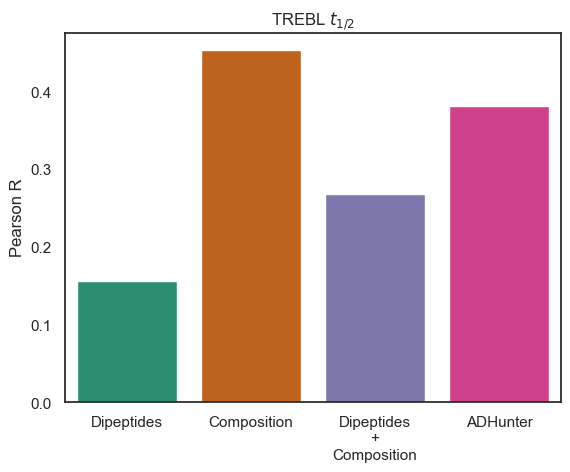

In [23]:
pe_r_2mer, _ = pearsonr(regr.predict(X_2mer_test).flatten(), y_2mer_test.flatten())
pe_r_aa, _ = pearsonr(regr_single.predict(X_aa_test).flatten(), y_aa_test.flatten())
pe_r_comb, _ = pearsonr(regr_comb.predict(X_comb_test).flatten(), y_comb_test.flatten())

sns.barplot({
    "Dipeptides": pe_r_2mer, 
    "Composition": pe_r_aa, 
    "Dipeptides\n+\nComposition": pe_r_comb,
    "ADHunter": pe,
    }, errorbar=None, palette='Dark2')
plt.title("TREBL $t_{1/2}$")
plt.ylabel("Pearson R")
plt.show()

/var/folders/1w/3zhjqj3d3ljgvrrqp77lpv6m0000gn/T/ipykernel_13738/3761217550.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot({


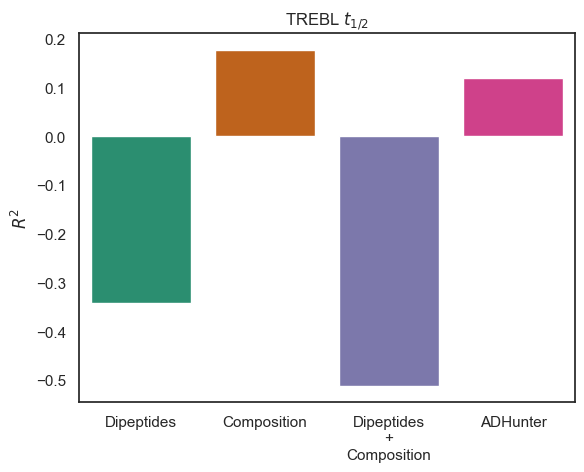

In [24]:
sns.barplot({
    "Dipeptides": r2_2mer, 
    "Composition": r2_aa, 
    "Dipeptides\n+\nComposition": r2_comb,
    "ADHunter": r2,
    }, errorbar=None, palette='Dark2')
plt.title("TREBL $t_{1/2}$")
plt.ylabel("$R^2$")
plt.show()

# Make a function to do ADHunter + regressions altogether

In [25]:
np.random.randint(0, 100)

72

In [18]:
import random
def run_everything(seed, debug=False):
    np.random.seed(seed)  # For numpy
    random.seed(seed)
    pl.seed_everything(seed)
    df = pd.read_csv("../data/EC_TREBLactivities_20250321_v2.csv")
    df["AAseq"] = df["Tile"].apply(lambda seq: "".join(Seq(seq).translate()))
    # print(sum(df[df["AAseq"].str.len() == 40]) / len(df))
    df = df[df["AAseq"].str.len() == 40]
    df = df.loc[df.loc[:, ['AAseq', 'Vmax']].drop_duplicates().index]
    df_ad = df[df["Activity"]=="active"].copy()

    seqs = df_ad["AAseq"].to_numpy()
    # activity = df["Vmax"].to_numpy()
    # y_bin = (df_ad["Activity"] == "active").values


    t_half = df_ad["T1/2"].to_numpy().reshape(-1, 1)
    t_scaler = preprocessing.StandardScaler().fit(t_half)
    t_half_scaled = t_scaler.transform(t_half)
    y_cont = t_half_scaled
    # Split t1/2 into above/below median
    t_half_median = np.median(t_half)
    y_bin = t_half > t_half_median
    # Add speed annotations to df_ad
    df_ad["speed"] = "fast"
    df_ad.loc[y_bin.flatten(), "speed"] = "slow"

    # convert seqs to integer valued vectors
    alphabet="ACDEFGHIKLMNPQRSTVWY"
    aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
    i_to_aa = {i:aa for i, aa in enumerate(alphabet)}
    X = np.asarray([[aa_to_i[aa] for aa in x] for x in seqs])
    # Do train test split
    train, val, test, indices = get_stratified_split(X, y_bin, y_cont, as_tensor=True, seed=seed)
    (X_train, y_bin_train, y_cont_train) = train
    (X_val, y_bin_val, y_cont_val) = val
    (X_test, y_bin_test, y_cont_test) = test
    train_idx, val_index, test_index = indices

    test_val_indices = np.array([i for i in range(X.shape[0]) if i not in train_idx])
    val_idx = test_val_indices[val_index]
    test_idx = test_val_indices[test_index]
    # train_indices = np.array([i for i in np.arange(len(X)) if i not in test_val_indices])
    if debug:
        return train_idx, val_idx, test_idx
    # REGRESSIONS
    count_kmers = lambda seq, pair: seq.count(pair)
    dipeptides = ["".join(j) for j in [i for i in product(alphabet, repeat=2)]]
    # dipeptides = ["".join(j) for j in [i for i in combinations(alphabet, 2)]]
    get_input_2mers = lambda seq: np.array([count_kmers(seq, pair) for pair in dipeptides])
    get_input_single = lambda seq: np.array([count_kmers(seq, aa) for aa in alphabet])
    # Additional functions to double count where applicable: eg AAAA -> 4 AA instead of 2 AA
    count_kmers_all = lambda seq, pair: len(re.findall(f'(?=({pair}))', seq))
    get_input_2mers_all = lambda seq: np.array([count_kmers(seq, pair) for pair in dipeptides])

    X_2mers = np.vstack(df_ad["AAseq"].apply(get_input_2mers_all).values)
    X_aa = np.vstack(df_ad["AAseq"].apply(get_input_single).values)
    X_combined = np.hstack([X_2mers, X_aa])
    X_2mer_train, X_2mer_test, y_2mer_train, y_2mer_test = train_test_split_copy(X_2mers, y_cont, train_idx, test_val_indices)
    X_aa_train, X_aa_test, y_aa_train, y_aa_test = train_test_split_copy(X_aa, y_cont, train_idx, test_val_indices)
    X_comb_train, X_comb_test, y_comb_train, y_comb_test = train_test_split_copy(X_combined, y_cont, train_idx, test_val_indices)

    regr = LinearRegression()
    regr.fit(X_2mer_train, y_2mer_train)
    r2_2mer = regr.score(X_2mer_test, y_2mer_test)
    print(r2_2mer) 

    regr_single = LinearRegression()
    regr_single.fit(X_aa_train, y_aa_train)
    r2_aa = regr_single.score(X_aa_test, y_aa_test)
    print(r2_aa) 

    regr_comb = LinearRegression()
    regr_comb.fit(X_comb_train, y_comb_train)
    r2_comb = regr_comb.score(X_comb_test, y_comb_test)
    print(r2_comb) 

    sp_r_2mer, _ = spearmanr(regr.predict(X_2mer_test), y_2mer_test)
    sp_r_aa, _ = spearmanr(regr_single.predict(X_aa_test), y_aa_test)
    sp_r_comb, _ = spearmanr(regr_comb.predict(X_comb_test), y_comb_test)
    pe_r_2mer, _ = pearsonr(regr.predict(X_2mer_test).flatten(), y_2mer_test.flatten())
    pe_r_aa, _ = pearsonr(regr_single.predict(X_aa_test).flatten(), y_aa_test.flatten())
    pe_r_comb, _ = pearsonr(regr_comb.predict(X_comb_test).flatten(), y_comb_test.flatten())
    # ADHunter
    sp, pe, r2 = train_adhunter(X_train, y_cont_train, X_val, y_cont_val, X_test, y_cont_test)

    spearmans = (sp_r_2mer, sp_r_aa, sp_r_comb, sp)
    pearsons = (pe_r_2mer, pe_r_aa, pe_r_comb, pe)
    r2s = (r2_2mer, r2_aa, r2_comb, r2)
    return spearmans, pearsons, r2s

In [19]:
spearmans, pearsons, r2s = [], [], []
trs, tes, vs = [], [], []
for i in range(10):
    # tr, v, te = run_everything(np.random.randint(0, 1000), debug=True)
    # trs.append(tr)
    # tes.append(te)
    # vs.append(v)
    s, p, r = run_everything(i)
    spearmans.append(s)
    pearsons.append(p)
    r2s.append(r)

Global seed set to 0
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory ../misc/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ActCNN           | 96.8 K
1 | loss_fn   | MSELoss          | 0     
2 | rmse      | MeanSquaredError | 0     
3 | pearsonr  | PearsonC

-0.07017145655295565
0.07812606753453721
-0.05865198477944311
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 17.98it/s]val_rmse 1.9252488613128662
val_pearsonr -0.1572374701499939
val_spearmanr -0.4634172320365906
                                                                           

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 18/18 [00:00<00:00, 36.31it/s, loss=0.875, v_num=25]val_rmse 1.1799120903015137
val_pearsonr 0.0962299332022667
val_spearmanr 0.3546082079410553
Epoch 1: 100%|██████████| 18/18 [00:00<00:00, 80.67it/s, loss=0.782, v_num=25]val_rmse 1.0615028142929077
val_pearsonr 0.1533983051776886
val_spearmanr 0.2877035140991211
Epoch 2: 100%|██████████| 18/18 [00:00<00:00, 84.90it/s, loss=0.686, v_num=25]val_rmse 1.0603104829788208
val_pearsonr 0.17981265485286713
val_spearmanr 0.2939777970314026
Epoch 3: 100%|██████████| 18/18 [00:00<00:00, 86.54it/s, loss=0.526, v_num=25]val_rmse 1.1283625364303589
val_pearsonr 0.017562536522746086
val_spearmanr 0.14062178134918213
Epoch 4: 100%|██████████| 18/18 [00:00<00:00, 61.80it/s, loss=0.463, v_num=25]val_rmse 1.1132009029388428
val_pearsonr 0.08707670867443085
val_spearmanr 0.24740728735923767
Epoch 5: 100%|██████████| 18/18 [00:00<00:00, 74.84it/s, loss=0.398, v_num=25]val_rmse 1.0607807636260986
val_pearsonr 0.18482908606529236


Global seed set to 1
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory ../misc/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ActCNN           | 96.8 K
1 | loss_fn   | MSELoss          | 0     
2 | rmse      | MeanSquaredError | 0     
3 | pearsonr  | PearsonC

-0.48988949827543227
0.19239423663257949
-0.46108265992528086
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 154.08it/s]val_rmse 1.8536938428878784
val_pearsonr -0.2940845191478729
val_spearmanr -0.5054899454116821
                                                                            

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning

Epoch 0: 100%|██████████| 18/18 [00:00<00:00, 67.03it/s, loss=1.06, v_num=26] val_rmse 0.8774182200431824
val_pearsonr 0.5544746518135071
val_spearmanr 0.3417882025241852
Epoch 1: 100%|██████████| 18/18 [00:00<00:00, 85.59it/s, loss=0.928, v_num=26]val_rmse 0.7036746740341187
val_pearsonr 0.5652047395706177
val_spearmanr 0.3446102738380432
Epoch 2: 100%|██████████| 18/18 [00:00<00:00, 82.91it/s, loss=0.743, v_num=26]val_rmse 0.6715313792228699
val_pearsonr 0.5990390777587891
val_spearmanr 0.28643134236335754
Epoch 3: 100%|██████████| 18/18 [00:00<00:00, 77.40it/s, loss=0.758, v_num=26]val_rmse 0.7268887758255005
val_pearsonr 0.5712223052978516
val_spearmanr 0.30761992931365967
Epoch 4: 100%|██████████| 18/18 [00:00<00:00, 72.72it/s, loss=0.603, v_num=26]val_rmse 0.7103822231292725
val_pearsonr 0.6321730613708496
val_spearmanr 0.37625858187675476
Epoch 5: 100%|██████████| 18/18 [00:00<00:00, 81.37it/s, loss=0.442, v_num=26]val_rmse 0.6831724047660828
val_pearsonr 0.576141893863678
val_s

Global seed set to 2
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory ../misc/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ActCNN           | 96.8 K
1 | loss_fn   | MSELoss          | 0     
2 | rmse      | MeanSquaredError | 0     
3 | pearsonr  | PearsonC

-0.06583365614007808
0.06172513797056478
-0.04193337407412501
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 117.63it/s]val_rmse 2.015550374984741
val_pearsonr -0.2610631287097931
val_spearmanr -0.52496337890625
                                                                            

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning

Epoch 0: 100%|██████████| 18/18 [00:00<00:00, 75.26it/s, loss=0.887, v_num=27]val_rmse 1.1430140733718872
val_pearsonr 0.38766494393348694
val_spearmanr 0.4193131625652313
Epoch 1: 100%|██████████| 18/18 [00:00<00:00, 87.86it/s, loss=0.679, v_num=27]val_rmse 1.053876519203186
val_pearsonr 0.34795036911964417
val_spearmanr 0.4143904745578766
Epoch 2: 100%|██████████| 18/18 [00:00<00:00, 87.27it/s, loss=0.593, v_num=27]val_rmse 1.1032719612121582
val_pearsonr 0.23741845786571503
val_spearmanr 0.38840433955192566
Epoch 3: 100%|██████████| 18/18 [00:00<00:00, 83.28it/s, loss=0.472, v_num=27]val_rmse 1.158801555633545
val_pearsonr 0.19318491220474243
val_spearmanr 0.3541770577430725
Epoch 4: 100%|██████████| 18/18 [00:00<00:00, 79.92it/s, loss=0.381, v_num=27]val_rmse 1.1369686126708984
val_pearsonr 0.1618000864982605
val_spearmanr 0.1138119176030159
Epoch 5: 100%|██████████| 18/18 [00:00<00:00, 87.41it/s, loss=0.305, v_num=27]val_rmse 1.1940410137176514
val_pearsonr 0.06806809455156326
val

Global seed set to 3
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory ../misc/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ActCNN           | 96.8 K
1 | loss_fn   | MSELoss          | 0     
2 | rmse      | MeanSquaredError | 0     
3 | pearsonr  | PearsonC

-0.1106936890456951
0.046052546595159005
-0.12214845128337082
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 133.67it/s]val_rmse 2.0586254596710205
val_pearsonr -0.24950531125068665
val_spearmanr -0.5047637224197388
                                                                            

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning

Epoch 0: 100%|██████████| 18/18 [00:00<00:00, 62.30it/s, loss=0.907, v_num=28]val_rmse 1.3146675825119019
val_pearsonr 0.19784335792064667
val_spearmanr 0.18178106844425201
Epoch 1: 100%|██████████| 18/18 [00:00<00:00, 82.91it/s, loss=0.786, v_num=28]val_rmse 1.1237640380859375
val_pearsonr 0.21635547280311584
val_spearmanr 0.33511659502983093
Epoch 2: 100%|██████████| 18/18 [00:00<00:00, 88.61it/s, loss=0.621, v_num=28]val_rmse 1.1375848054885864
val_pearsonr 0.10941115021705627
val_spearmanr 0.23719298839569092
Epoch 3: 100%|██████████| 18/18 [00:00<00:00, 87.44it/s, loss=0.485, v_num=28]val_rmse 1.13571035861969
val_pearsonr 0.20140106976032257
val_spearmanr 0.3667185306549072
Epoch 4: 100%|██████████| 18/18 [00:00<00:00, 86.45it/s, loss=0.477, v_num=28]val_rmse 1.1278467178344727
val_pearsonr 0.1552891731262207
val_spearmanr 0.35250601172447205
Epoch 5: 100%|██████████| 18/18 [00:00<00:00, 88.25it/s, loss=0.409, v_num=28]val_rmse 1.175827980041504
val_pearsonr 0.10557350516319275
v

Global seed set to 4
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory ../misc/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ActCNN           | 96.8 K
1 | loss_fn   | MSELoss          | 0     
2 | rmse      | MeanSquaredError | 0     
3 | pearsonr  | PearsonC

-0.6657371765497877
0.011364600781827328
-0.5760391816272792
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 119.52it/s]val_rmse 1.7916744947433472
val_pearsonr -0.2882162034511566
val_spearmanr -0.4442678689956665
                                                                            

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning

Epoch 0: 100%|██████████| 18/18 [00:00<00:00, 72.22it/s, loss=1.05, v_num=29]val_rmse 0.8453499674797058
val_pearsonr 0.19835636019706726
val_spearmanr 0.2308211475610733
Epoch 1: 100%|██████████| 18/18 [00:00<00:00, 87.47it/s, loss=0.718, v_num=29]val_rmse 0.662473201751709
val_pearsonr 0.1271086186170578
val_spearmanr 0.1997329741716385
Epoch 2: 100%|██████████| 18/18 [00:00<00:00, 86.64it/s, loss=0.665, v_num=29]val_rmse 0.6387124061584473
val_pearsonr 0.08192511647939682
val_spearmanr 0.21096767485141754
Epoch 3: 100%|██████████| 18/18 [00:00<00:00, 87.17it/s, loss=0.564, v_num=29]val_rmse 0.7553370594978333
val_pearsonr 0.12974844872951508
val_spearmanr 0.30752551555633545
Epoch 4: 100%|██████████| 18/18 [00:00<00:00, 83.66it/s, loss=0.412, v_num=29]val_rmse 0.6455578207969666
val_pearsonr 0.15180213749408722
val_spearmanr 0.20259280502796173
Epoch 5: 100%|██████████| 18/18 [00:00<00:00, 82.54it/s, loss=0.37, v_num=29] val_rmse 0.6387443542480469
val_pearsonr 0.04507379233837128
v

Global seed set to 5
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory ../misc/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ActCNN           | 96.8 K
1 | loss_fn   | MSELoss          | 0     
2 | rmse      | MeanSquaredError | 0     
3 | pearsonr  | PearsonC

-0.27749748323817935
-0.012272066287960515
-0.2981229607329423
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 98.64it/s]val_rmse 1.780609130859375
val_pearsonr -0.2161644548177719
val_spearmanr -0.4880831837654114
                                                                           

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning

Epoch 0: 100%|██████████| 18/18 [00:00<00:00, 57.91it/s, loss=1.12, v_num=30] val_rmse 0.9621784687042236
val_pearsonr 0.2745119035243988
val_spearmanr 0.2564272880554199
Epoch 1: 100%|██████████| 18/18 [00:00<00:00, 77.14it/s, loss=1.1, v_num=30]  val_rmse 0.8199251294136047
val_pearsonr 0.358324259519577
val_spearmanr 0.41863417625427246
Epoch 2: 100%|██████████| 18/18 [00:00<00:00, 77.76it/s, loss=0.796, v_num=30]val_rmse 0.8572376370429993
val_pearsonr 0.35840535163879395
val_spearmanr 0.30599766969680786
Epoch 3: 100%|██████████| 18/18 [00:00<00:00, 86.04it/s, loss=0.72, v_num=30] val_rmse 0.7897700071334839
val_pearsonr 0.4896928369998932
val_spearmanr 0.3991551995277405
Epoch 4: 100%|██████████| 18/18 [00:00<00:00, 84.65it/s, loss=0.608, v_num=30]val_rmse 0.9913613200187683
val_pearsonr 0.36149197816848755
val_spearmanr 0.3444395363330841
Epoch 5: 100%|██████████| 18/18 [00:00<00:00, 90.50it/s, loss=0.456, v_num=30]val_rmse 0.8456630110740662
val_pearsonr 0.507156252861023
val_s

Global seed set to 6
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory ../misc/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ActCNN           | 96.8 K
1 | loss_fn   | MSELoss          | 0     
2 | rmse      | MeanSquaredError | 0     
3 | pearsonr  | PearsonC

-0.19306069388395852
0.08346361629321886
-0.18632884475010925
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 123.34it/s]val_rmse 2.003150224685669
val_pearsonr -0.18998835980892181
val_spearmanr -0.4897550344467163
                                                                            

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning

Epoch 0: 100%|██████████| 18/18 [00:00<00:00, 65.41it/s, loss=0.967, v_num=31]val_rmse 1.0727925300598145
val_pearsonr 0.3154189884662628
val_spearmanr 0.4018096625804901
Epoch 1: 100%|██████████| 18/18 [00:00<00:00, 87.95it/s, loss=0.748, v_num=31]val_rmse 1.0145676136016846
val_pearsonr 0.355694055557251
val_spearmanr 0.45242562890052795
Epoch 2: 100%|██████████| 18/18 [00:00<00:00, 87.55it/s, loss=0.721, v_num=31]val_rmse 0.9521591663360596
val_pearsonr 0.49765101075172424
val_spearmanr 0.30196088552474976
Epoch 3: 100%|██████████| 18/18 [00:00<00:00, 88.68it/s, loss=0.688, v_num=31]val_rmse 1.0228571891784668
val_pearsonr 0.4225747585296631
val_spearmanr 0.4180087149143219
Epoch 4: 100%|██████████| 18/18 [00:00<00:00, 88.16it/s, loss=0.566, v_num=31]val_rmse 0.9691707491874695
val_pearsonr 0.5957587361335754
val_spearmanr 0.2606041133403778
Epoch 5: 100%|██████████| 18/18 [00:00<00:00, 87.40it/s, loss=0.425, v_num=31]val_rmse 0.9406118392944336
val_pearsonr 0.4726886451244354
val_s

Global seed set to 7
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory ../misc/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ActCNN           | 96.8 K
1 | loss_fn   | MSELoss          | 0     
2 | rmse      | MeanSquaredError | 0     
3 | pearsonr  | PearsonC

-0.2769599731711754
0.08178403771540066
-0.2536728961939301
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 135.08it/s]val_rmse 1.949424386024475
val_pearsonr -0.3263297975063324
val_spearmanr -0.577096164226532
                                                                            

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning

Epoch 0: 100%|██████████| 18/18 [00:00<00:00, 75.70it/s, loss=0.907, v_num=32]val_rmse 0.9258645176887512
val_pearsonr 0.39213624596595764
val_spearmanr 0.4458460509777069
Epoch 1: 100%|██████████| 18/18 [00:00<00:00, 86.54it/s, loss=0.676, v_num=32]val_rmse 0.8783167600631714
val_pearsonr 0.34424224495887756
val_spearmanr 0.3915835916996002
Epoch 2: 100%|██████████| 18/18 [00:00<00:00, 85.13it/s, loss=0.588, v_num=32]val_rmse 0.8614299893379211
val_pearsonr 0.3859129846096039
val_spearmanr 0.382262259721756
Epoch 3: 100%|██████████| 18/18 [00:00<00:00, 77.79it/s, loss=0.526, v_num=32]val_rmse 0.9515650868415833
val_pearsonr 0.08355963230133057
val_spearmanr 0.15939898788928986
Epoch 4: 100%|██████████| 18/18 [00:00<00:00, 81.96it/s, loss=0.449, v_num=32]val_rmse 0.9255502223968506
val_pearsonr 0.36075565218925476
val_spearmanr 0.2880520522594452
Epoch 5: 100%|██████████| 18/18 [00:00<00:00, 74.30it/s, loss=0.393, v_num=32]val_rmse 0.8872889876365662
val_pearsonr 0.36006981134414673
va

Global seed set to 8
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory ../misc/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ActCNN           | 96.8 K
1 | loss_fn   | MSELoss          | 0     
2 | rmse      | MeanSquaredError | 0     
3 | pearsonr  | PearsonC

0.027438947923412615
0.11449471824097668
0.004778599561374497
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 129.68it/s]val_rmse 2.045729875564575
val_pearsonr -0.3051944971084595
val_spearmanr -0.4649049639701843
                                                                            

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning

Epoch 0: 100%|██████████| 18/18 [00:00<00:00, 69.54it/s, loss=0.915, v_num=33]val_rmse 1.2481156587600708
val_pearsonr 0.4987606704235077
val_spearmanr 0.34353241324424744
Epoch 1: 100%|██████████| 18/18 [00:00<00:00, 65.90it/s, loss=0.739, v_num=33]val_rmse 0.9350299835205078
val_pearsonr 0.6180974245071411
val_spearmanr 0.3374532461166382
Epoch 2: 100%|██████████| 18/18 [00:00<00:00, 87.41it/s, loss=0.734, v_num=33]val_rmse 1.0235611200332642
val_pearsonr 0.5408825874328613
val_spearmanr 0.15120269358158112
Epoch 3: 100%|██████████| 18/18 [00:00<00:00, 87.04it/s, loss=0.49, v_num=33] val_rmse 1.0730278491973877
val_pearsonr 0.35240039229393005
val_spearmanr 0.29313284158706665
Epoch 4: 100%|██████████| 18/18 [00:00<00:00, 87.13it/s, loss=0.458, v_num=33]val_rmse 1.0416728258132935
val_pearsonr 0.41998571157455444
val_spearmanr 0.284468412399292
Epoch 5: 100%|██████████| 18/18 [00:00<00:00, 86.65it/s, loss=0.352, v_num=33]val_rmse 1.0120364427566528
val_pearsonr 0.5559410452842712
val

Global seed set to 9
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory ../misc/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ActCNN           | 96.8 K
1 | loss_fn   | MSELoss          | 0     
2 | rmse      | MeanSquaredError | 0     
3 | pearsonr  | PearsonC

-0.20554999751317538
0.002695739457283741
-0.1823522647700211
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 150.80it/s]val_rmse 1.9737119674682617
val_pearsonr -0.18392498791217804
val_spearmanr -0.4771624207496643
                                                                            

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning

Epoch 0: 100%|██████████| 18/18 [00:00<00:00, 59.40it/s, loss=0.916, v_num=34]val_rmse 1.4008816480636597
val_pearsonr 0.13804471492767334
val_spearmanr 0.29648199677467346
Epoch 1: 100%|██████████| 18/18 [00:00<00:00, 87.01it/s, loss=0.737, v_num=34]val_rmse 1.1858190298080444
val_pearsonr 0.23776547610759735
val_spearmanr 0.37633728981018066
Epoch 2: 100%|██████████| 18/18 [00:00<00:00, 88.69it/s, loss=0.63, v_num=34] val_rmse 1.2913881540298462
val_pearsonr 0.17348137497901917
val_spearmanr 0.4059857130050659
Epoch 3: 100%|██████████| 18/18 [00:00<00:00, 82.07it/s, loss=0.556, v_num=34]val_rmse 1.2067564725875854
val_pearsonr 0.21524100005626678
val_spearmanr 0.23771853744983673
Epoch 4: 100%|██████████| 18/18 [00:00<00:00, 85.79it/s, loss=0.39, v_num=34] val_rmse 1.384945034980774
val_pearsonr 0.00551217095926404
val_spearmanr 0.3130437135696411
Epoch 5: 100%|██████████| 18/18 [00:00<00:00, 86.22it/s, loss=0.328, v_num=34]val_rmse 1.3168838024139404
val_pearsonr 0.15926842391490936

In [21]:
# sorted(tes[-1]) == sorted(tes[1])
# # pd.DataFrame(np.vstack(trs)).T
# ttt = np.vstack(trs)
# ttt.sort()
# print(sorted(trs[0]) == sorted(trs[1]))
# print(sorted(tes[0]) == sorted(tes[1]))
# print(sorted(vs[0]) == sorted(vs[1]))
# # tes
# cb = lambda i: np.sort(np.concatenate([vs[i], tes[i]]))
# all(cb(0) == cb(1))

In [43]:
# y_bin

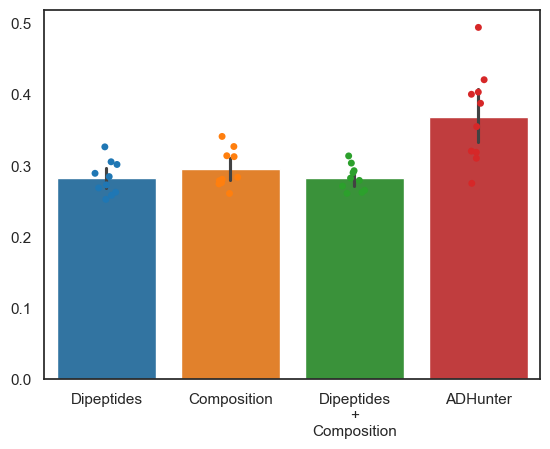

,Dipeptides,Composition,Dipeptides\n+\nComposition,ADHunter
0,0.285012,0.313069,0.293328,0.494727
1,0.273432,0.327299,0.279682,0.319166
2,0.253072,0.261351,0.262842,0.320853
3,0.326832,0.279220,0.314091,0.400749
4,0.263122,0.274795,0.265862,0.275581
5,0.269091,0.281359,0.271753,0.421187
6,0.305863,0.284167,0.304036,0.310841
7,0.258806,0.341493,0.261541,0.388061
8,0.302085,0.276427,0.282863,0.403838
9,0.289657,0.314346,0.290515,0.355316


In [25]:
cols = ["Dipeptides", "Composition", "Dipeptides\n+\nComposition", "ADHunter",]
sdf = pd.DataFrame(spearmans)
sdf.columns = cols

sns.barplot(sdf)
sns.stripplot(sdf)
plt.show()

sdf

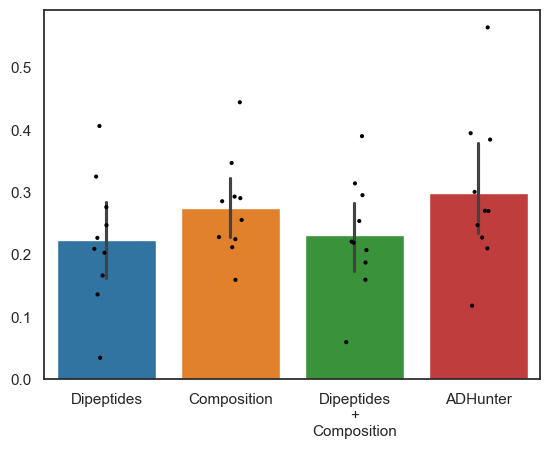

,Dipeptides,Composition,Dipeptides\n+\nComposition,ADHunter
0,0.209260,0.285584,0.220823,0.227381
1,0.247103,0.444213,0.253856,0.210064
2,0.276211,0.255604,0.295282,0.384400
3,0.226829,0.228186,0.219170,0.394581
4,0.136194,0.224763,0.159734,0.118194
5,0.406161,0.211802,0.389886,0.564159
6,0.203034,0.290506,0.207209,0.269908
7,0.034687,0.293012,0.059732,0.270208
8,0.325071,0.346884,0.314210,0.300560
9,0.166462,0.159572,0.187357,0.247332


In [23]:
pdf = pd.DataFrame(pearsons)
pdf.columns = cols

sns.barplot(pdf)
sns.stripplot(pdf, palette=list('k'*4), s=3)
plt.show()

pdf

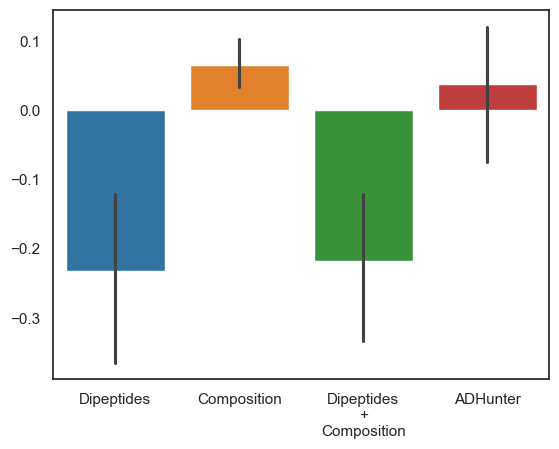

,Dipeptides,Composition,Dipeptides\n+\nComposition,ADHunter
0,-0.070171,0.078126,-0.058652,0.034928
1,-0.489889,0.192394,-0.461083,-0.069555
2,-0.065834,0.061725,-0.041933,0.140279
3,-0.110694,0.046053,-0.122148,0.132567
4,-0.665737,0.011365,-0.576039,-0.368912
5,-0.277497,-0.012272,-0.298123,0.285147
6,-0.193061,0.083464,-0.186329,0.040403
7,-0.276960,0.081784,-0.253673,0.065270
8,0.027439,0.114495,0.004779,0.086174
9,-0.205550,0.002696,-0.182352,0.033419


In [24]:
cols = ["Dipeptides", "Composition", "Dipeptides\n+\nComposition", "ADHunter",]
r2df = pd.DataFrame(r2s)
r2df.columns = cols
sns.barplot(r2df)
plt.show()
r2df

<Axes: xlabel='variable', ylabel='value'>

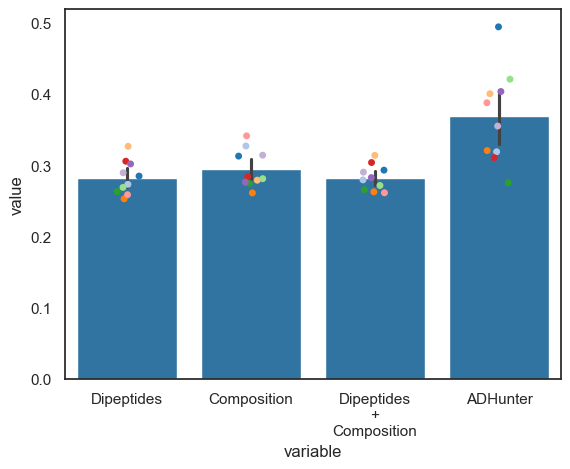

In [58]:
sdf = pd.DataFrame(spearmans)
sdf.columns = cols
sdf = sdf.reset_index().melt(id_vars='index', value_vars=cols)
sns.barplot(sdf, x="variable", y="value")
sns.stripplot(sdf, x="variable", y="value", hue='index', palette="tab20", legend=False)

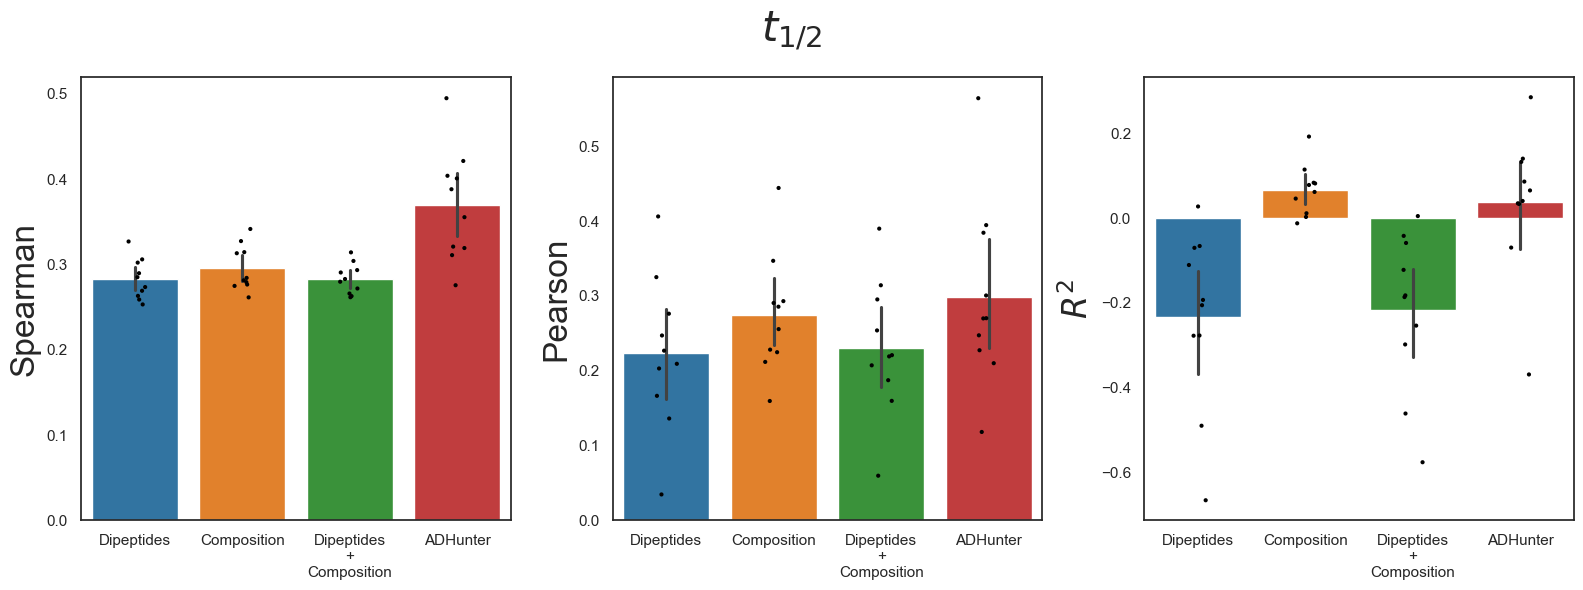

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(16,6))
cols = ["Dipeptides", "Composition", "Dipeptides\n+\nComposition", "ADHunter",]

sdf = pd.DataFrame(spearmans)
sdf.columns = cols
pdf = pd.DataFrame(pearsons)
pdf.columns = cols
r2df = pd.DataFrame(r2s)
r2df.columns = cols

sns.barplot(sdf, ax=axs[0])
sns.stripplot(sdf, palette=list('k'*4), s=3, ax=axs[0])
axs[0].set_ylabel("Spearman", fontsize=24)


sns.barplot(pdf, ax=axs[1])
sns.stripplot(pdf, palette=list('k'*4), s=3, ax=axs[1])
axs[1].set_ylabel("Pearson", fontsize=24)

sns.barplot(r2df, ax=axs[2])
sns.stripplot(r2df, palette=list('k'*4), s=3, ax=axs[2])
axs[2].set_ylabel("$R^2$", fontsize=24)
fig.suptitle("$t_{1/2}$", fontsize=30)
fig.tight_layout()
plt.show()

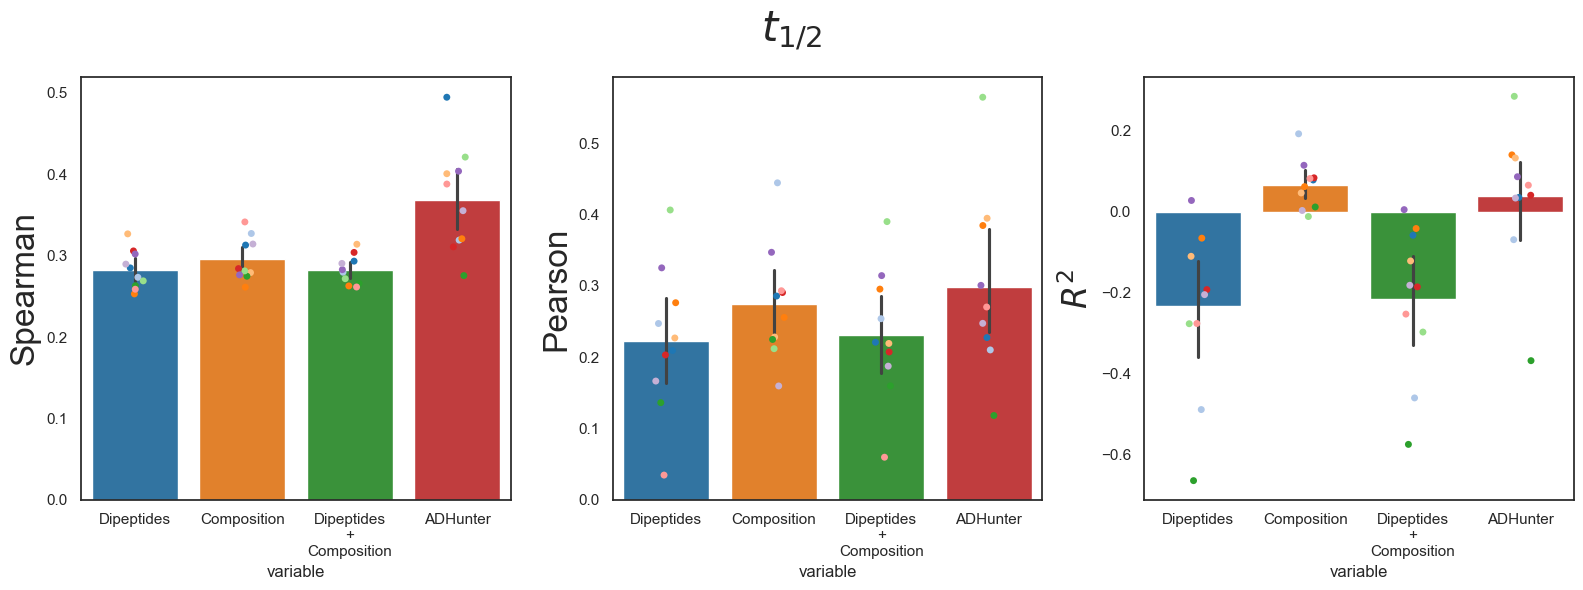

In [61]:
# Creating DataFrames
sdf = pd.DataFrame(spearmans)
sdf.columns = cols
sdf = sdf.reset_index().melt(id_vars='index', value_vars=cols)

pdf = pd.DataFrame(pearsons)
pdf.columns = cols
pdf = pdf.reset_index().melt(id_vars='index', value_vars=cols)

r2df = pd.DataFrame(r2s)
r2df.columns = cols
r2df = r2df.reset_index().melt(id_vars='index', value_vars=cols)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(16,6))

# Spearman plot
sns.barplot(data=sdf, x="variable", y="value", ax=axs[0], hue="variable")
sns.stripplot(data=sdf, x="variable", y="value", hue='index', palette="tab20", legend=False, ax=axs[0])
axs[0].set_ylabel("Spearman", fontsize=24)

# Pearson plot
sns.barplot(data=pdf, x="variable", y="value", ax=axs[1], hue="variable")
sns.stripplot(data=pdf, x="variable", y="value", hue='index', palette="tab20", legend=False, ax=axs[1])
axs[1].set_ylabel("Pearson", fontsize=24)

# R^2 plot
sns.barplot(data=r2df, x="variable", y="value", ax=axs[2], hue="variable")
sns.stripplot(data=r2df, x="variable", y="value", hue='index', palette="tab20", legend=False, ax=axs[2])
axs[2].set_ylabel("$R^2$", fontsize=24)

# Title and layout adjustments
fig.suptitle("$t_{1/2}$", fontsize=30)
fig.tight_layout()
plt.show()
